## PyTorch 常用工具模块

In [1]:
import os

import torch as t
from torch.utils import data
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from tensorboard_logger import Logger
import visdom
from PIL import Image
import numpy as np

### 1. 数据处理

#### 1.1 数据加载

In [2]:
class DogCat(data.Dataset):
    def __init__(self, root):
        imgs = os.listdir(root)
        # 所有图片的绝对路径
        # 这里不实际加载图片, 只是指定路径, 当调用 __getitem__ 时才会真正读图片
        self.imgs = [os.path.join(root, img) for img in imgs]
    
    def __getitem__(self, index):
        img_path = self.imgs[index]
        # dog->1, cat->0
        label = 1 if 'dog' in img_path.split('/')[-1] else 0
        pil_img = Image.open(img_path)
        array = np.asarray(pil_img)
        data = t.from_numpy(array)
        return data, label

    def __len__(self):
        return len(self.imgs)

In [3]:
dataset = DogCat('./data_dogvscat/dogcat/')
img, label = dataset[0]
print('data[0]:', img.size(), label)

for img, label in dataset:
    print(img.size(), img.float().mean(), label)

data[0]: torch.Size([375, 499, 3]) 1
torch.Size([375, 499, 3]) tensor(150.5079) 1
torch.Size([500, 497, 3]) tensor(106.4915) 0
torch.Size([499, 379, 3]) tensor(171.8085) 0
torch.Size([375, 499, 3]) tensor(116.8138) 1
torch.Size([374, 499, 3]) tensor(115.5177) 0
torch.Size([236, 289, 3]) tensor(130.3004) 0
torch.Size([377, 499, 3]) tensor(151.7174) 1
torch.Size([400, 300, 3]) tensor(128.1550) 1


#### 1.2 加载数据时, 进行 transform 处理

In [4]:
transform = T.Compose([
    T.Resize(224),  # 缩放图片, 保持长宽比不变, 最短边为224像素
    T.CenterCrop(224),  # 从图片中间切出244*224的图片
    T.ToTensor(),  # 将图片转成Tensor, 归一化至[0, 1]
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 标准化至[-1, 1], 规定均值和标准差
])

class DogCat(data.Dataset):
    def __init__(self, root, transforms=None):
        imgs = os.listdir(root)
        self.imgs = [os.path.join(root, img) for img in imgs]
        self.transforms = transforms
    
    def __getitem__(self, index):
        img_path = self.imgs[index]
        label = 1 if 'dog' in img_path.split('/')[-1] else 0
        data = Image.open(img_path)
        if self.transforms:
            data = self.transforms(data)
        return data, label
    
    def __len__(self):
        return len(self.imgs)

In [5]:
dataset = DogCat('./data_dogvscat/dogcat/', transforms=transform)
img, label = dataset[0]
print('data[0]:', img.size(), label)

for img, label in dataset:
    print(img.size(), img.float().mean(), label)

data[0]: torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) tensor(0.1176) 1
torch.Size([3, 224, 224]) tensor(-0.1654) 0
torch.Size([3, 224, 224]) tensor(0.3892) 0
torch.Size([3, 224, 224]) tensor(-0.0649) 1
torch.Size([3, 224, 224]) tensor(-0.0462) 0
torch.Size([3, 224, 224]) tensor(0.0711) 0
torch.Size([3, 224, 224]) tensor(0.2234) 1
torch.Size([3, 224, 224]) tensor(-0.0267) 1


#### 1.3 使用 ImageFolder 加载数据

In [6]:
dataset = ImageFolder('./data_dogvscat/dogcat_2/')

In [7]:
# 查看label和文件夹名的映射关系
dataset.class_to_idx

{'cat': 0, 'dog': 1}

In [8]:
# 查看所有图片的路径和对应的label
dataset.imgs

[('./data_dogvscat/dogcat_2/cat/cat.12484.jpg', 0),
 ('./data_dogvscat/dogcat_2/cat/cat.12485.jpg', 0),
 ('./data_dogvscat/dogcat_2/cat/cat.12486.jpg', 0),
 ('./data_dogvscat/dogcat_2/cat/cat.12487.jpg', 0),
 ('./data_dogvscat/dogcat_2/dog/dog.12496.jpg', 1),
 ('./data_dogvscat/dogcat_2/dog/dog.12497.jpg', 1),
 ('./data_dogvscat/dogcat_2/dog/dog.12498.jpg', 1),
 ('./data_dogvscat/dogcat_2/dog/dog.12499.jpg', 1)]

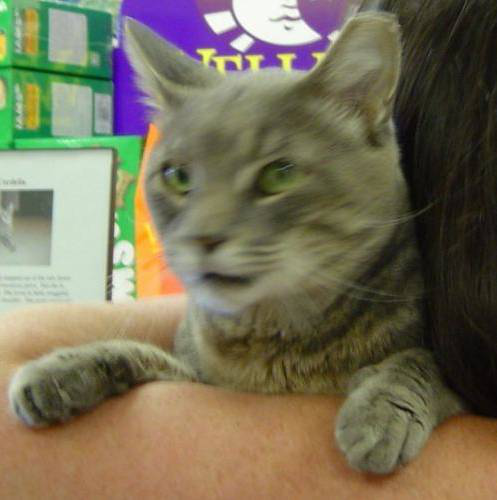

In [9]:
# 没有任何的transform, 所以返回的还是PIL Image对象
dataset[0][0]

In [10]:
dataset[0][1]

0

In [11]:
# 使用ImageFolder 加载时, 加上transform
normalize = T.Normalize(mean=[0.4, 0.4, 0.4], std=[0.2, 0.2, 0.2])
transform = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normalize
])

dataset = ImageFolder('./data_dogvscat/dogcat_2/', transform=transform)

In [12]:
# 深度学习中图片数据一般保存成 CxHxW, 即 通道数x图片高x图片宽
dataset[0][0].size()

torch.Size([3, 224, 224])

In [13]:
T.ToPILImage(dataset[0][0] * 0.2 + 0.4)

ToPILImage(mode=tensor([[[0.0392, 0.0431, 0.0510,  ..., 0.5451, 0.5490, 0.5451],
         [0.0353, 0.0431, 0.0510,  ..., 0.5490, 0.5608, 0.5686],
         [0.0392, 0.0431, 0.0549,  ..., 0.5569, 0.5765, 0.5882],
         ...,
         [0.5216, 0.5059, 0.4980,  ..., 0.7176, 0.7216, 0.7255],
         [0.5294, 0.5137, 0.5098,  ..., 0.7216, 0.7216, 0.7255],
         [0.5412, 0.5255, 0.5216,  ..., 0.7333, 0.7255, 0.7216]],

        [[0.0314, 0.0353, 0.0431,  ..., 0.5529, 0.5333, 0.5098],
         [0.0275, 0.0353, 0.0431,  ..., 0.5529, 0.5451, 0.5255],
         [0.0314, 0.0353, 0.0471,  ..., 0.5569, 0.5569, 0.5451],
         ...,
         [0.5490, 0.5333, 0.5255,  ..., 0.5451, 0.5490, 0.5529],
         [0.5569, 0.5412, 0.5294,  ..., 0.5490, 0.5490, 0.5529],
         [0.5608, 0.5451, 0.5412,  ..., 0.5608, 0.5529, 0.5490]],

        [[0.0353, 0.0392, 0.0549,  ..., 0.4980, 0.4784, 0.4510],
         [0.0314, 0.0392, 0.0549,  ..., 0.4980, 0.4902, 0.4706],
         [0.0353, 0.0392, 0.0588,  ..., 0.

#### 1.4 使用 DataLoader 加载数据

In [14]:
dataloader = DataLoader(dataset, batch_size=3, shuffle=True, num_workers=0, drop_last=False)

In [15]:
data_iter = iter(dataloader)
imgs, labels = next(data_iter)
imgs.size()  # batch_size, channels, height, width

torch.Size([3, 3, 224, 224])

In [16]:
# 在Dataloader中实现自定义的collate_fn, 处理像出现某个样本无法读取等问题时, 将出错的样本剔除等操作.

class NewDogCat(DogCat):  # 继承前面实现的 DogCat 数据集
    def __getitem__(self, index):
        try:
            return super(NewDogCat, self).__getitem__(index)
        except:
            return None, None

def my_collate_fn(batch):
    """
    batch中每个元素形如: (data, label)
    """
    # 过滤掉为None的数据
    batch = list(filter(lambda x: x[0] is not None, batch))
    if len(batch) == 0:
        return t.Tensor()
    return default_collate(batch)  # 用默认方式拼接过滤后的batch数据

In [17]:
dataset = NewDogCat('./data_dogvscat/dogcat_wrong/', transforms=transform)
dataset[5]

(tensor([[[-0.3922, -0.3922, -0.3922,  ...,  0.1176,  0.1176,  0.1176],
          [-0.3725, -0.3922, -0.3922,  ...,  0.0980,  0.0980,  0.0980],
          [-0.3725, -0.3725, -0.3725,  ...,  0.0980,  0.0980,  0.0784],
          ...,
          [ 1.1569,  1.1765,  1.1765,  ...,  2.6667,  2.6667,  2.6863],
          [ 1.1569,  1.1765,  1.1765,  ...,  2.6667,  2.6667,  2.6863],
          [ 1.1569,  1.1765,  1.1765,  ...,  2.6863,  2.6863,  2.7059]],
 
         [[-0.5098, -0.5098, -0.5098,  ...,  0.0392,  0.0392,  0.0392],
          [-0.4902, -0.5098, -0.5098,  ...,  0.0196,  0.0196,  0.0196],
          [-0.4902, -0.4902, -0.4902,  ...,  0.0196,  0.0196,  0.0000],
          ...,
          [ 1.0588,  1.0784,  1.0784,  ...,  2.6471,  2.6863,  2.7059],
          [ 1.0588,  1.0784,  1.0784,  ...,  2.6667,  2.6863,  2.7059],
          [ 1.0588,  1.0784,  1.0784,  ...,  2.6863,  2.7059,  2.7255]],
 
         [[-0.7451, -0.7451, -0.7451,  ..., -0.1961, -0.1961, -0.1961],
          [-0.7255, -0.7451,

In [18]:
dataloader = DataLoader(dataset, batch_size=2, collate_fn=my_collate_fn, num_workers=1, shuffle=True)
for batch_datas, batch_labels in dataloader:
    print(batch_datas.size(), batch_labels.size())

torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([1, 3, 224, 224]) torch.Size([1])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([1, 3, 224, 224]) torch.Size([1])


### 2. 可视化工具

#### 2.1 Tensorboard

In [19]:
# 构建logger对象, logdir 用来指定log文件的保存路径
# flush_secs 用来指定刷新同步间隔
logger = Logger(logdir='./experiment_cnn', flush_secs=2)
for i in range(100):
    logger.log_value('loss', 10-i**0.5, step=i)
    logger.log_value('accuracy', i**0.5/10)

#### 2.2 Visdom

In [20]:
# 需通过python -m visdom.server命令启动visdom服务，
# 或通过nohup python -m visdom.server &命令将服务放至后台运行

# 新建一个连接客户端
# 指定env = u'test1'，默认端口为8097，host是‘localhost'
vis = visdom.Visdom(env=u'test1', use_incoming_socket=False)

x = t.arange(1, 30, 0.01, dtype=t.float32)
y = t.sin(x)
vis.line(X=x, Y=y, win='sinx', opts={'title': 'y=sin(x)'})

Without the incoming socket you cannot receive events from the server or register event handlers to your Visdom client.


'sinx'

In [21]:
for i in range(0, 10):
    x = t.Tensor([i])
    y = x
    vis.line(X=x, Y=y, win='polynomial', update='append' if i > 0 else None)  # append 追加数据

x = t.arange(0, 9, 0.1)
y = (x ** 2) / 9
vis.line(X=x, Y=y, win='polynomial', name='this is a new Trace', update='replace')

'polynomial'

In [22]:
# 可视化一个随机的黑白图片
vis.image(t.randn(64, 64).numpy())

# 随机可视化一张彩色图片
vis.image(t.randn(3, 64, 64).numpy(), win='random2')

# 可视化36张随机的彩色图片，每一行6张
vis.images(t.randn(36, 3, 64, 64).numpy(), nrow=6, win='random3', opts={'title': 'random_imgs'})

'random3'

In [23]:
vis.text(u'''<h1>Hello Visdom</h1><br>Visdom是Facebook专门为<b>PyTorch</b>开发的一个可视化工具，
         在内部使用了很久，在2017年3月份开源了它。
         
         Visdom十分轻量级，但是却有十分强大的功能，支持几乎所有的科学运算可视化任务''',
        win='visdom',
        opts={'title': u'visdom简介'})

'visdom'